In [8]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [13]:
import pandas as pd 
import numpy as np 

# To fetch financial data
import yfinance as yf

# For visualisation
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
%matplotlib inline 

In [11]:
# Set the ticker as 'EURUSD=X'
forex_data = yf.download('EURUSD=X', start='2019-01-02', end='2021-12-31')

# Set the index to a datetime object
forex_data.index = pd.to_datetime(forex_data.index)

# Display the last five rows
forex_data.tail()
forex_data.to_csv('forex_data.csv')

[*********************100%***********************]  1 of 1 completed


In [12]:
forex_data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-27,1.132387,1.133500,1.130416,1.132426,1.132426,0
2021-12-28,1.132978,1.133600,1.129038,1.133003,1.133003,0
2021-12-29,1.131337,1.137001,1.127536,1.131478,1.131478,0
2021-12-30,1.135976,1.135976,1.130071,1.136015,1.136015,0
2021-12-31,1.132323,1.137915,1.130506,1.132503,1.132503,0


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,1.146132,1.149700,1.134572,1.146171,1.146171,0
2019-01-03,1.131734,1.140914,1.131734,1.131811,1.131811,0
2019-01-04,1.139095,1.141774,1.134816,1.139108,1.139108,0
2019-01-07,1.141292,1.147447,1.140524,1.141044,1.141044,0
2019-01-08,1.147934,1.148633,1.142465,1.147974,1.147974,0


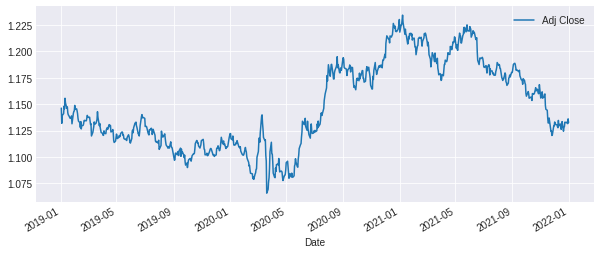

In [22]:
# Put data into Pandas Dataframe
df = pd.DataFrame(forex_data)
print(df.columns)
# df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].applymap(lambda x: 1.0/x)
display(df.head())
df.plot(y='Adj Close', figsize=(10,4))

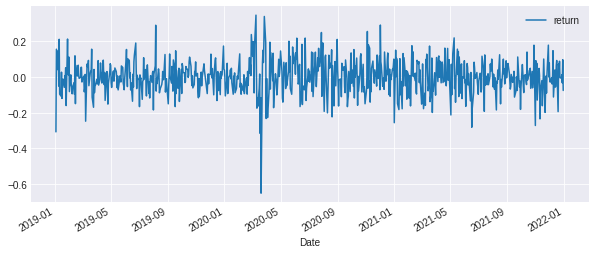

In [24]:
# Normalize aclose value
# We use this value to train model

df['return'] = df['Adj Close'] - df['Adj Close'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range

df.plot(y='return', figsize=(10,4))

In [25]:
# Make label, 1 as rising price, 0 as falling price

df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
# df.dropna(inplace=True)
df.tail()

,Open,High,Low,Close,Adj Close,Volume,return,label
Date,,,,,,,,
2021-12-27,1.132387,1.133500,1.130416,1.132426,1.132426,0,-0.006600,1
2021-12-28,1.132978,1.133600,1.129038,1.133003,1.133003,0,0.012379,0
2021-12-29,1.131337,1.137001,1.127536,1.131478,1.131478,0,-0.032710,1
2021-12-30,1.135976,1.135976,1.130071,1.136015,1.136015,0,0.097290,0
2021-12-31,1.132323,1.137915,1.130506,1.132503,1.132503,0,-0.075310,0


In [29]:
df.shape

(782, 8)

In [55]:
# Make training dataset

n_features = 60 # number of features

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    # print(i)
    if i<n_features:
        continue
    
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    # print(_x)
    _y = np.array(df[i:i+1]['label'])
    # print(_y)
    # print(_y.shape)
    # print(train_y.shape)
    # print(train_x.shape)
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

(722, 60)
(722,)
% of Class0 : 0.501385
% of Class1 : 0.498615


In [57]:
# Define Model and fit
# Here we use 95% of data for training, and last 5% for testing

from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)

train_len = int(len(train_x)*0.95)
print(train_len)
clf.fit(train_x[:train_len], train_y[:train_len])
print(train_x[train_len:].shape)
print(train_y[train_len:].shape)
accuracy = clf.score(train_x[train_len:], train_y[train_len:])
print('Testing Accuracy: %f' % accuracy)

685
(37, 60)
(37,)
Testing Accuracy: 0.513514


,return,label,pred,won,pnl,equity
31,-0.000308,0.0,1.0,False,-3.077984,103.077888
32,0.000577,1.0,1.0,True,5.773306,108.851194
33,-0.001526,0.0,0.0,True,15.255213,124.106407
34,0.004537,1.0,1.0,True,45.373440,169.479847
35,-0.003512,0.0,0.0,True,35.122633,204.602480


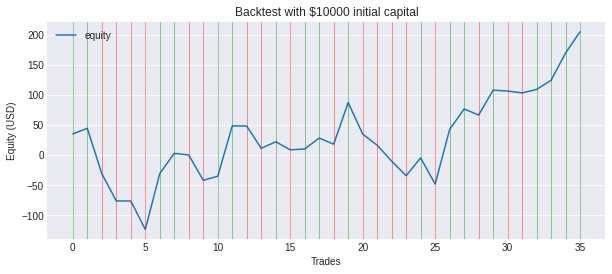

In [58]:
# Predict test data

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = 10000.0
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')

Net Profit            : $204.60
Number Winning Trades : 18
Number Losing Trades  : 17
Percent Profitable    : 51.43%
Avg Win Trade         : $36.503
Avg Los Trade         : $-26.615
Largest Win Trade     : $92.678
Largest Los Trade     : $-75.170
Profit Factor         : 1.45


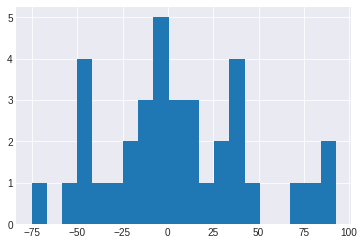

In [59]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)